### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"


# 7. Working with Multi-table Datasets

The preprocessing steps in a data science workflow often involve more than one table.
Data scientists usually write independent scripts for such data preparation as there is no easy way to include it in a machine learning pipeline.
Lale introduced preprocessing operators for performing join, filter, map, groupby, aggregate, etc. as part of end-to-end sklearn-style pipelines.
We will demonstrate these operators in the context of a classification task.

This tutorial has following sections:

-   [7.1 Dataset](#dataset)
-	[7.2 Lale Operators for Multi-table Handling](#laleoperators)
-	[7.3 End to End Classification Pipeline](#classification)
-	[7.4 Summary](#summary)


<a id="dataset"></a>
## 7.1 Dataset

For this demonstration, we transformed the [credit-g](https://www.openml.org/d/31) dataset from OpenML to a multi-table format. We split the dataset into 3 tables: `loan_application`, `bank_account_info` and `existing_credits_info`. The table `loan_application` serves as our primary table, and we treat the other two tables as providing additional information related to the applicant's bank account and existing credits. As one can see, this is very close to a real life scenario where information is present in multiple tables in normalized forms. We created a primary key column `id` as a proxy to the loan applicant's identity number.

The dataset can be accessed by invoking `fetch_creditg_multitable_dataset` method from `lale.datasets.multitable`. It returns a list of `lale.datasets.data_schemas.DataFrameWithSchema` objects which are pandas dataframes with additional information such as `table_name`.

In [1]:
from lale.datasets.multitable import fetch_creditg_multitable_dataset
tables_list = fetch_creditg_multitable_dataset()

Let's inspect the dataset:

In [2]:
from lale.datasets.data_schemas import get_table_name
for table in tables_list:
    print(type(table))
    print(f"{get_table_name(table)}:")
    print(table)

<class 'lale.datasets.data_schemas.DataFrameWithSchema'>
bank_account_info:
    checking_status    savings_status   id
863     no checking            >=1000  863
748     no checking  no known savings  748
64      no checking              <100   64
798     no checking  no known savings  798
52      no checking              <100   52
..              ...               ...  ...
76               <0              <100   76
48      no checking              <100   48
503        0<=X<200        100<=X<500  503
263     no checking              <100  263
808        0<=X<200              <100  808

[1000 rows x 3 columns]
<class 'lale.datasets.data_schemas.DataFrameWithSchema'>
loan_application:
     duration                  credit_history              purpose  \
863      27.0  critical/other existing credit  furniture/equipment   
748      21.0                   existing paid             used car   
64       24.0                   existing paid             radio/tv   
798      24.0              d

<a id="laleoperators"></a>
## 7.2 Lale Operators for Multi-table Handling

Lale has a [number of operators](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.html#relational-algebra-operators) that correspond to relational algebra operations such as `Join`, `GroupBy`, `Aggregate`, etc.
These allow joining multiple tables and creating new features after the join by performing groupby and aggregate or doing preprocessing such as filter, project, etc.

In this example, we will join the `loan_application` and `bank_account_info` using equi-join based on `id`.
We will then join the `loan_application` and `existing_credits_info` and re-create the `existing_credits` column from the original single table dataset by counting the number of credits per id from the join output.

In [3]:
from lale.lib.rasl import Scan, Join, GroupBy, Aggregate
from lale.expressions import it, count

[`Scan`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.scan.html?highlight=Scan#lale.lib.rasl.scan.Scan) allows us to read a single dataframe from the list and outputs of multiple `Scans` combined using `&` can be the input to [`Join`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.join.html?highlight=Join#lale.lib.rasl.join.Join). `Join` takes a list of join predicates as a hyperparameter. Note the use of `it.<table_name>` and `it.<table_name>.<column_name>` which are special expressions defined by Lale with a keyword `it`.

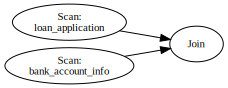

In [4]:
join_bank_info = (
       (Scan(table=it.loan_application) & Scan(table=it.bank_account_info))
    >> Join(pred=[it.loan_application.id == it.bank_account_info.id]))

join_bank_info.visualize()

[`GroupBy`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.group_by.html?highlight=GroupBy#lale.lib.rasl.group_by.GroupBy) expects a list of group by expressions and it has to be followed by [`Aggregate`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.aggregate.html). `Aggregate` expects a dictionary with the name of the column being created as the key and an aggregate function. Here, we re-create the `existing_credits` count column by using [`count`](https://lale.readthedocs.io/en/latest/modules/lale.expressions.html?highlight=it#lale.expressions.count) as an aggregate function. Other functions that can be used with `Aggregate` are listed [here](https://lale.readthedocs.io/en/latest/modules/lale.expressions.html?highlight=it#module-lale.expressions).

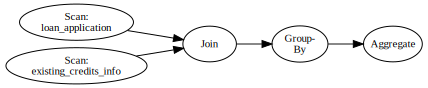

In [5]:
existing_credit_feature = (
       (Scan(table=it.loan_application) & Scan(table=it.existing_credits_info))
    >> Join(pred=[it.loan_application.id == it.existing_credits_info.id])
     >> GroupBy(by=[it.id]) #primary key of main table
     >> Aggregate(columns={'existing_credits': count(it.credit_number)}))

existing_credit_feature.visualize()

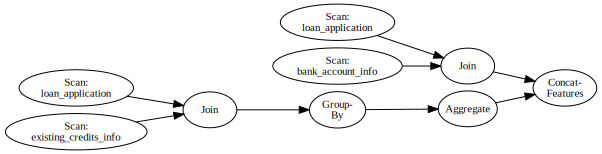

In [6]:
from lale.lib.lale import ConcatFeatures

all_features = ((join_bank_info & existing_credit_feature)
    >> ConcatFeatures)
all_features.visualize()

In [7]:
df =all_features.transform(tables_list)

from lale.lib.xgboost import XGBClassifier as XGBoost

In [8]:
classification_pipeline = all_features